### Mapping every CCD to pixels at different resolutions



In [46]:
import numpy as np
from astropy.io import fits
import healpy as hp
import pandas as pd
from desiutil.plots import plot_sky_binned
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import matplotlib.path as mplPath

### Retrieving the relevant CCD Data

In [47]:
#decamCCD = fits.open('../bricks_data/ccds-annotated-90prime-dr9.fits')


decamCCD = fits.open('../../bricks_data/ccds-annotated-decam-dr9.fits')
mosaicCCD = fits.open('../../bricks_data/ccds-annotated-mosaic-dr9.fits')
bassCCD = fits.open('../../bricks_data/ccds-annotated-90prime-dr9.fits')
print(decamCCD[1].columns)


ColDefs(
    name = 'image_filename'; format = '120A'
    name = 'image_hdu'; format = 'I'
    name = 'camera'; format = '5A'
    name = 'expnum'; format = 'K'
    name = 'plver'; format = '8A'
    name = 'procdate'; format = '19A'
    name = 'plprocid'; format = '7A'
    name = 'ccdname'; format = '3A'
    name = 'object'; format = '35A'
    name = 'propid'; format = '10A'
    name = 'filter'; format = '1A'
    name = 'exptime'; format = 'E'
    name = 'mjd_obs'; format = 'D'
    name = 'airmass'; format = 'E'
    name = 'fwhm'; format = 'E'
    name = 'width'; format = 'I'
    name = 'height'; format = 'I'
    name = 'ra_bore'; format = 'D'
    name = 'dec_bore'; format = 'D'
    name = 'crpix1'; format = 'E'
    name = 'crpix2'; format = 'E'
    name = 'crval1'; format = 'D'
    name = 'crval2'; format = 'D'
    name = 'cd1_1'; format = 'E'
    name = 'cd1_2'; format = 'E'
    name = 'cd2_1'; format = 'E'
    name = 'cd2_2'; format = 'E'
    name = 'yshift'; format = 'L'
    name = 

In [48]:
dataDecam = decamCCD[1].data
dataMosaic = mosaicCCD[1].data
dataBass = bassCCD[1].data

In [49]:
#ra0 = np.concatenate((dataDecam.field('ra0'), dataMosaic.field('ra0'), dataBass.field('ra0')), axis=0)
#print(len(ra0))
ra0_decam = dataDecam.field('ra0')
ra0_mosaic = dataMosaic.field('ra0')
ra0_bass = dataBass.field('ra0')
print(len(ra0_decam) + len(ra0_mosaic) + len(ra0_bass))

6776431


In [50]:
ra0 = np.concatenate((dataDecam.field('ra0'), dataMosaic.field('ra0'), dataBass.field('ra0')), axis=0)
dec0 = np.concatenate((dataDecam.field('dec0'), dataMosaic.field('dec0'), dataBass.field('dec0')), axis=0)

ra1 = np.concatenate((dataDecam.field('ra1'), dataMosaic.field('ra1'), dataBass.field('ra1')), axis=0)
dec1 = np.concatenate((dataDecam.field('dec1'), dataMosaic.field('dec1'), dataBass.field('dec1')), axis=0)

ra2 = np.concatenate((dataDecam.field('ra2'), dataMosaic.field('ra2'), dataBass.field('ra2')), axis=0)
dec2 = np.concatenate((dataDecam.field('dec2'), dataMosaic.field('dec2'), dataBass.field('dec2')), axis=0)

ra3 = np.concatenate((dataDecam.field('ra3'), dataMosaic.field('ra3'), dataBass.field('ra3')), axis=0)
dec3 = np.concatenate((dataDecam.field('dec3'), dataMosaic.field('dec3'), dataBass.field('dec3')), axis=0)



### Defining Healpy Utilities

In [51]:
def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


NSIDE = 512
NPIX = hp.nside2npix(NSIDE)

6776431
[[ 0.70633408  0.11278378 -0.69883617]
 [ 0.70547397  0.11794218 -0.69885344]
 [ 0.70367345  0.11763693 -0.70071766]
 [ 0.70453374  0.11248107 -0.7006998 ]] DECAM Ordering, 0,1,2,3
[2670465 2670466 2670467 2672412 2672413 2672414 2672415 2674356 2674357
 2674358 2674359]
[[ 0.70547397  0.11794218 -0.69885344]
 [ 0.70633408  0.11278378 -0.69883617]
 [ 0.70453374  0.11248107 -0.7006998 ]
 [ 0.70367345  0.11763693 -0.70071766]] BASS Ordering, 1,0,3,2
[2670465 2670466 2670467 2672412 2672413 2672414 2672415 2674356 2674357
 2674358 2674359]
[[ 0.70453374  0.11248107 -0.7006998 ]
 [ 0.70367345  0.11763693 -0.70071766]
 [ 0.70547397  0.11794218 -0.69885344]
 [ 0.70633408  0.11278378 -0.69883617]] MzLS Ordering, 3,2,1,0
[2670465 2670466 2670467 2672412 2672413 2672414 2672415 2674356 2674357
 2674358 2674359]


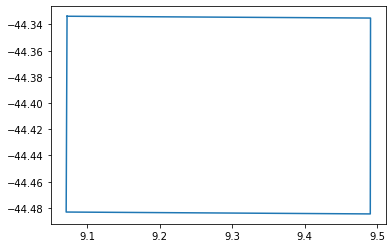

In [52]:
# This cell proves that ordering does not matter for the polygon functions I wrote, they return the same pixels regardless of catalogue

print(len(ra0))
cc = 345
xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
plt.plot(xs, ys)

x_coord_polygon = np.array([ra0[cc], ra1[cc], ra2[cc], ra3[cc]])
y_coord_polygon = np.array([dec0[cc], dec1[cc], dec2[cc], dec3[cc]])
theta, phi = raDec2thetaPhi(x_coord_polygon, y_coord_polygon)
ccd_vertices_3d = hp.ang2vec(theta=theta, phi=phi)
print(ccd_vertices_3d, "DECAM Ordering, 0,1,2,3")
print(hp.query_polygon(nside=NSIDE, vertices=ccd_vertices_3d, inclusive=True))

x_coord_polygon = np.array([ra1[cc], ra0[cc], ra3[cc], ra2[cc]])
y_coord_polygon = np.array([dec1[cc], dec0[cc], dec3[cc], dec2[cc]])
theta, phi = raDec2thetaPhi(x_coord_polygon, y_coord_polygon)
ccd_vertices_3d = hp.ang2vec(theta=theta, phi=phi)
print(ccd_vertices_3d, "BASS Ordering, 1,0,3,2")
print(hp.query_polygon(nside=NSIDE, vertices=ccd_vertices_3d, inclusive=True))

x_coord_polygon = np.array([ra3[cc], ra2[cc], ra1[cc], ra0[cc]])
y_coord_polygon = np.array([dec3[cc], dec2[cc], dec1[cc], dec0[cc]])
theta, phi = raDec2thetaPhi(x_coord_polygon, y_coord_polygon)
ccd_vertices_3d = hp.ang2vec(theta=theta, phi=phi)
print(ccd_vertices_3d, "MzLS Ordering, 3,2,1,0")
print(hp.query_polygon(nside=NSIDE, vertices=ccd_vertices_3d, inclusive=True))



### First Step: Identify which CCD is associated to which pixel

In [ ]:
pixel2ccd_dict = defaultdict(list)
count_ex = 0

# In this function, I am first converting every CCD into a given polygon using its corner coordinates
# Afterwards, I am using the ang2vec function and the hp.query_polygon function, to identify every pixel that features the given CCD
# Then, I am creating a dictionary that lists all CCDs for a given pixel

for no in range(len(ra0)):
    x_coord_polygon = np.array([ra0[no], ra1[no], ra2[no], ra3[no]])
    y_coord_polygon = np.array([dec0[no], dec1[no], dec2[no], dec3[no]])
    theta, phi = raDec2thetaPhi(x_coord_polygon, y_coord_polygon)

    ccd_vertices_3d = hp.ang2vec(theta=theta, phi=phi)

    # Now, Im getting all healpy pixels that a given CCD covers
    try:
        pixels_for_ccd = hp.query_polygon(nside=NSIDE, vertices=ccd_vertices_3d, inclusive=True)
    except:
        count_ex += 1
        continue
    # This will give me the mapping CCD --> Pixel
    # Now, im reverting the mapping
    # For every pixel that a given CCD cuts, enter the CCD into the pixel dictionary
    # Mapping: Pixel --> CCDs
    for pixel in pixels_for_ccd:
        pixel2ccd_dict[pixel].append(no)

    if no % 40000 == 0:
        print(no, count_ex)

# ToDo: Find out what happens to 2467 CCDs where query polygon throws unknown exception

0 0
40000 0
80000 0
120000 0
160000 0
200000 0
240000 0
280000 0
320000 0
360000 0


In [ ]:
keys = list(pixel2ccd_dict.keys())
c = 0
for k in keys:
    c += (len(pixel2ccd_dict[k]))

print(c / len(pixel2ccd_dict))

In [ ]:
#Exporting to Pickle, since this process only needs to be run once
#The filename number (e.g.256) indicates the NSIDE of the Healpy pixels used to generate the pixelisation

with open(f'../../bricks_data/pixel2ccd_{NSIDE}.pickle', 'wb') as f:
    pickle.dump(pixel2ccd_dict, f)
    f.close()


# with open('pixel2ccd_256.pickle') as f:
#data = pickle.load(f)

# Note that brickpixel2ccd files only feature Decals, pixel2ccd files also the two other surveys


#### Plotting the Boundaries of the different CCDs that are associated to an arbitrary pixel


No of Pixels that are covered by CCDs: 1784378
Pixel with most CCDs covering it: 2307377
Number of CCDs covering pixel : 2975
Average number of CCDs per pixel: 14.645682697276026
1784378
Number of CCDs that are cutting pixel number  2307377 : 2975


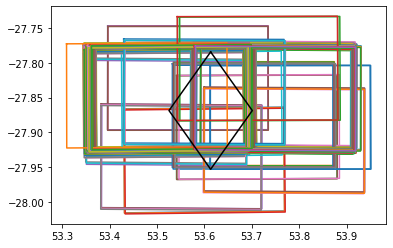

In [43]:
# Validate the pixel2ccd_dict is correct
# For any pixel you try, the ccds for subpixel should be a subset of ccds for pixel

NSIDE = 512
with open(f'../../bricks_data/pixel2ccd_{NSIDE}_non_inclusive.pickle', 'rb') as f:
    pixel2ccd_dict= pickle.load(f)
    f.close()

pixel_keys = pixel2ccd_dict.keys()
print("No of Pixels that are covered by CCDs:", len(pixel_keys))

maxa = 0
maxb = 0
agg = 0
for k in pixel_keys:
    a = len(pixel2ccd_dict[k])
    agg += a
    if a > maxa:
        maxa = a
        maxb = k
print("Pixel with most CCDs covering it:", maxb)
print("Number of CCDs covering pixel :", maxa)
print("Average number of CCDs per pixel:", agg / len(pixel_keys))


pixel_number = 2307377
# print(pixel2ccd_dict.keys())
print(len(pixel2ccd_dict.keys()))

#for i, keys in enumerate(pixel2ccd_dict.keys()):
#break
ccd = pixel2ccd_dict[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd:
    #coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
    xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
    ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
    plt.plot(xs, ys)
#if i > 3:
#break

pixel_boundary = hp.boundaries(nside=NSIDE, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(), lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0], pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1], pixel_boundary_raDec[1][0])

plt.plot(pixel_boundary_raDec[0], pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()

No of Pixels that are covered by CCDs: 446195
Pixel with most CCDs covering it: 581271
Number of CCDs covering pixel : 2951
Average number of CCDs per pixel: 14.62690079449568
446195
Number of CCDs that are cutting pixel number  581271 : 2951


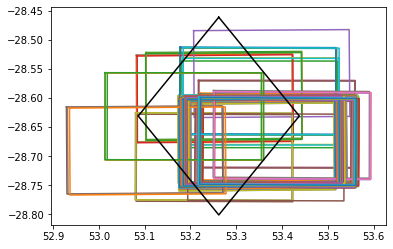

In [44]:
NSIDE = 256
with open(f'../../bricks_data/pixel2ccd_{NSIDE}_non_inclusive.pickle', 'rb') as f:
    pixel2ccd_dict= pickle.load(f)
    f.close()

#Validate the pixel2ccd_dict is correct
# For any pixel you try, the ccds for subpixel should be a subset of ccds for pixel

pixel_keys = pixel2ccd_dict.keys()
print("No of Pixels that are covered by CCDs:", len(pixel_keys))

maxa = 0
maxb = 0
agg = 0
for k in pixel_keys:
    a = len(pixel2ccd_dict[k])
    agg += a
    if a > maxa:
        maxa = a
        maxb = k
print("Pixel with most CCDs covering it:", maxb)
print("Number of CCDs covering pixel :", maxa)
print("Average number of CCDs per pixel:", agg / len(pixel_keys))

pixel_number = 581271
# print(pixel2ccd_dict.keys())
print(len(pixel2ccd_dict.keys()))

#for i, keys in enumerate(pixel2ccd_dict.keys()):
#break
ccd = pixel2ccd_dict[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd:
    #coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
    xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
    ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
    plt.plot(xs, ys)
#if i > 3:
#break

pixel_boundary = hp.boundaries(nside=NSIDE, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(), lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0], pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1], pixel_boundary_raDec[1][0])

plt.plot(pixel_boundary_raDec[0], pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()


### Mapping Smaller Subpixels to CCDs for Geometric Separation of Pixels

1. Using Any CCD that cuts a given Subpixel, many of these CCDs only marginally cut the Pixel in question (see image below)

In [85]:
subpixel2ccd_dict = defaultdict(list)
count_ex = 0
NSIDE_SUB = NSIDE * 16
NPIX_SUB = hp.nside2npix(NSIDE_SUB)

# In this function, I am first converting every CCD into a given polygon using its corner coordinates
# Afterwards, I am using the ang2vec function and the hp.query_polygon function, to identify every subpixel that features the given CCD
# Then, I am creating a dictionary that lists all CCDs for a given pixel

for no in range(len(ra0)):  #range(len(ra0)):
    x_coord_polygon = np.array([ra0[no], ra1[no], ra2[no], ra3[no]])
    y_coord_polygon = np.array([dec0[no], dec1[no], dec2[no], dec3[no]])
    theta, phi = raDec2thetaPhi(x_coord_polygon, y_coord_polygon)

    ccd_vertices_3d = hp.ang2vec(theta=theta, phi=phi)

    # Now, Im getting all healpy pixels that a given CCD covers
    try:
        subpixels_for_ccd = hp.query_polygon(nside=NSIDE_SUB, vertices=ccd_vertices_3d, inclusive=True)
    except:
        count_ex += 1
        continue
    # This will give me the mapping CCD --> Pixel
    # Now, im reverting the mapping
    # For every pixel that a given CCD cuts, enter the CCD into the pixel dictionary
    # Mapping: Pixel --> CCDs
    for pixel in subpixels_for_ccd:
        subpixel2ccd_dict[pixel].append(no)

    if no % 10000 == 0:
        print(no, count_ex)

# Find out what happens to 2467 CCDs where query polygon throws unknown exception

0 0
40000 0
80000 0
120000 0
160000 0
200000 0
240000 0
280000 0
320000 0
360000 0
400000 0
440000 0
480000 0
520000 0
560000 0
600000 0
640000 0
680000 0
720000 0
760000 0
800000 0
840000 0
880000 0
920000 0
960000 0
1000000 0
1040000 0
1080000 0
1120000 0
1160000 0
1200000 1
1240000 1
1280000 1
1320000 1
1360000 1
1400000 1
1440000 1
1480000 1
1520000 1
1560000 1
1600000 2
1640000 5
1680000 11
1720000 11
1760000 16
1800000 34
1840000 34
1880000 34
1920000 34
1960000 34
2000000 41
2040000 41
2080000 41
2120000 41
2160000 43
2200000 43
2240000 43
2280000 43
2320000 43
2360000 124
2400000 124
2440000 125
2480000 125
2520000 125
2560000 125
2600000 154
2640000 154
2680000 154
2720000 154
2760000 154
2800000 154
2840000 154
2880000 154
2920000 154
2960000 154
3000000 154
3040000 184
3080000 184
3120000 184
3160000 184
3200000 184
3240000 185
3280000 185
3320000 187
3360000 187
3400000 615
3440000 674
3480000 677
3520000 679
3560000 679
3600000 693
3640000 693
3680000 693
3720000 693
37600

In [ ]:
#Exporting to Pickle, since this process only needs to be run once
#The filename number (e.g.256) indicates the NSIDE of the Healpy pixels used to generate the pixalisation


with open('../bricks_data/pixel2ccd_2048.pickle', 'wb') as f:
    pickle.dump(subpixel2ccd_dict, f)
    f.close()


In [95]:
# Validate the subpixel2ccd_dict is correct
# For any pixel you try, the ccds for subpixel should be a subset of ccds for pixel

subpixel_keys = subpixel2ccd_dict.keys()
print(len(subpixel_keys))
print("All CCD's for pixel:", pixel2ccd_dict[459294])
print("All CCD's for subpixel:", subpixel2ccd_dict[29364464])

maxa = 0
maxb = 0
agg = 0
for k in subpixel_keys:
    a = len(subpixel2ccd_dict[k])
    agg += a
    if a > maxa:
        maxa = a
        maxb = k

print("Subpixel with most CCDs covering it:", maxb)
print("Number of CCDs covering subpixel :", maxa)
print("Average number of CCDs per subpixel:", agg / len(subpixel_keys))

28778546
All CCD's for pixel: [3844955, 3844960, 3844961, 3844966, 3844967, 4633849, 4633850, 4633855, 4633856, 4633863, 4970525, 4970531, 4970537, 4970591, 4970597, 4970603, 4970604, 5054410, 5054411, 5054416, 5054417, 5054424, 5062518, 5062524, 5062530, 5062531, 5062757, 5062763, 5062769, 5150348, 5150353, 5150354, 5150359, 5150360, 5150828, 5150889, 5150897, 5150902, 5150903, 5150908, 5150909, 5644493, 5760528, 5760534, 5760540, 5777260, 5859216, 5859277, 5914962, 5914963, 5914968, 5914969, 5914976, 6080938, 6080944, 6080950, 6080951]
All CCD's for subpixel: [3844960, 4633849, 4970597, 5054410, 5062524, 5150348, 5150353, 5150897, 5150902, 5914962, 6080944]
Subpixel with most CCDs covering it: 37016770
Number of CCDs covering subpixel : 9279
Average number of CCDs per subpixel: 21.160053325835154


28778546
Number of CCDs that are cutting pixel number  42004532 : 625


<ipython-input-15-6231a9f1f07e>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pixel_boundary = hp.boundaries(nside=NSIDE_SUB, pix=pixel_number, step=1)
<ipython-input-15-6231a9f1f07e>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

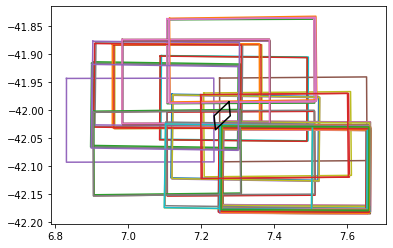

In [15]:
#Validating everything went as intended visually

pixel_number = 42004532
# print(pixel2ccd_dict.keys())
print(len(subpixel2ccd_dict.keys()))

#for i, keys in enumerate(pixel2ccd_dict.keys()):
#break
ccd = subpixel2ccd_dict[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd:
    #coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
    xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
    ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
    plt.plot(xs, ys)
#if i > 3:
#break

pixel_boundary = hp.boundaries(nside=NSIDE_SUB, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(), lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0], pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1], pixel_boundary_raDec[1][0])

plt.plot(pixel_boundary_raDec[0], pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()

### Mapping Smaller Subpixels to CCDs for Geometric Separation of Pixels

2. Using CCDs that include the center of a given Subpixel


In [7]:
# For DECAM, BASS, MzLS
with open('../bricks_data/pixel2ccd_2048.pickle', 'rb') as f:
    subpixel2ccd_dict = pickle.load(f)
    f.close()

In [16]:
subpixel2ccd_dict_non_inclusive = defaultdict(list)
count_ex = 0
NSIDE_SUB = NSIDE * 8
NPIX_SUB = hp.nside2npix(NSIDE_SUB)

In [17]:
subpixels = np.arange(0, NPIX_SUB)
subpixel_coords = hp.pix2ang(NSIDE_SUB, subpixels, lonlat=True)
ra_sub = subpixel_coords[0]
dec_sub = subpixel_coords[1]

raDec_sub = np.stack((ra_sub, dec_sub), axis=1)


In [21]:
with open('../bricks_data/pixel2ccd_2048_non_inclusive.pickle', 'rb') as f:
    subpixel2ccd_dict_non_inclusive = pickle.load(f)
    f.close()

In [22]:
print(len(subpixel2ccd_dict))
print(len(subpixel2ccd_dict_non_inclusive))


28778546
28536897


In [23]:
pix_total = list(subpixel2ccd_dict.keys())
pix_already_processed = list(subpixel2ccd_dict_non_inclusive.keys())
for pix in pix_already_processed:
    if pix in pix_total:
        pix_total.remove(pix)

print(len(pix_total))

KeyboardInterrupt: 

1. For every subpixel:
2. Get the center point from subpixel_coords
3. get all associated CCDs from subpixel2ccd dict
4. For each CCD, check if subpixel center is inside CCD
5. If yes, append CCD_no to subpixel2ccd_dict_non_inclusive

In [18]:
for i, subpix in enumerate(subpixel2ccd_dict):
    ccds_per_subpixel = subpixel2ccd_dict[subpix]

    # Iterate through all CCDs that cut this subpixel
    for no in ccds_per_subpixel:
        x0 = ra0[no]
        x1 = ra1[no]
        x2 = ra2[no]
        x3 = ra3[no]

        y0 = dec0[no]
        y1 = dec1[no]
        y2 = dec2[no]
        y3 = dec3[no]

        # Create a Bounding Box for this CCD
        boundingBoxPath = mplPath.Path(np.array([[x0, y0], [x1, y1], [x2, y2], [x3, y3], [x0, y0]]))

        if boundingBoxPath.contains_point(raDec_sub[subpix]):
            subpixel2ccd_dict_non_inclusive[subpix].append(no)

    if i % 42000 == 0:
        print(i / 42000000, "% completed")



0.0 % completed
0.001 % completed
0.002 % completed
0.003 % completed
0.004 % completed
0.005 % completed
0.006 % completed
0.007 % completed
0.008 % completed
0.009 % completed
0.01 % completed
0.011 % completed
0.012 % completed
0.013 % completed
0.014 % completed
0.015 % completed
0.016 % completed
0.017 % completed
0.018 % completed
0.019 % completed
0.02 % completed
0.021 % completed
0.022 % completed
0.023 % completed
0.024 % completed
0.025 % completed
0.026 % completed
0.027 % completed
0.028 % completed
0.029 % completed
0.03 % completed
0.031 % completed
0.032 % completed
0.033 % completed
0.034 % completed
0.035 % completed
0.036 % completed
0.037 % completed
0.038 % completed
0.039 % completed
0.04 % completed
0.041 % completed
0.042 % completed
0.043 % completed
0.044 % completed
0.045 % completed
0.046 % completed
0.047 % completed
0.048 % completed
0.049 % completed
0.05 % completed
0.051 % completed
0.052 % completed
0.053 % completed
0.054 % completed
0.055 % completed

0.458 % completed
0.459 % completed
0.46 % completed
0.461 % completed
0.462 % completed
0.463 % completed
0.464 % completed
0.465 % completed
0.466 % completed
0.467 % completed
0.468 % completed
0.469 % completed
0.47 % completed
0.471 % completed
0.472 % completed
0.473 % completed
0.474 % completed
0.475 % completed
0.476 % completed
0.477 % completed
0.478 % completed
0.479 % completed
0.48 % completed
0.481 % completed
0.482 % completed
0.483 % completed
0.484 % completed
0.485 % completed
0.486 % completed
0.487 % completed
0.488 % completed
0.489 % completed
0.49 % completed
0.491 % completed
0.492 % completed
0.493 % completed
0.494 % completed
0.495 % completed
0.496 % completed
0.497 % completed
0.498 % completed
0.499 % completed
0.5 % completed
0.501 % completed
0.502 % completed
0.503 % completed
0.504 % completed
0.505 % completed
0.506 % completed
0.507 % completed
0.508 % completed
0.509 % completed
0.51 % completed
0.511 % completed
0.512 % completed
0.513 % completed

In [12]:
print(subpixel2ccd_dict_non_inclusive.keys())

dict_keys([42004532])


In [20]:
with open('../bricks_data/pixel2ccd_2048_non_inclusive.pickle', 'wb') as f:
    pickle.dump(subpixel2ccd_dict_non_inclusive, f)
    f.close()

In [13]:
# Validate the subpixel2ccd_dict is correct
# For any pixel you try, the ccds for subpixel should be a subset of ccds for pixel

subpixel_keys = subpixel2ccd_dict_non_inclusive.keys()
print(len(subpixel_keys))
#print("All CCD's for pixel:", pixel2ccd_dict[459294])
print("All CCD's for subpixel:", subpixel2ccd_dict[42004532])
print("All CCD's for subpixel:", subpixel2ccd_dict_non_inclusive[42004532])

maxa = 0
maxb = 0
agg = 0
for k in subpixel_keys:
    a = len(subpixel2ccd_dict_non_inclusive[k])
    agg += a
    if a > maxa:
        maxa = a
        maxb = k

print("Subpixel with most CCDs covering it:", maxb)
print("Number of CCDs covering subpixel :", maxa)
print("Average number of CCDs per subpixel:", agg / len(subpixel_keys))

1
All CCD's for subpixel: [0, 60, 120, 180, 1560, 1620, 1680, 1740, 2520, 2580, 2640, 2700, 10260, 10320, 10380, 10440, 18180, 18240, 18300, 18360, 18660, 18720, 18780, 18840, 19200, 19260, 19320, 19380, 20520, 20580, 20640, 20700, 23280, 23340, 23400, 23460, 27780, 27840, 27900, 27960, 28260, 28320, 28380, 28440, 28800, 28861, 28922, 28983, 29471, 29532, 29593, 29654, 30508, 30569, 30630, 30691, 31850, 31911, 31972, 32033, 32338, 32399, 32460, 32521, 33436, 33497, 33558, 33619, 37767, 37828, 37889, 37950, 50577, 50638, 50699, 50760, 69670, 69731, 69792, 69853, 97608, 97669, 97730, 97791, 122008, 122069, 122130, 122191, 139393, 139454, 139515, 139576, 144439, 160682, 160743, 160804, 160865, 192690, 194476, 194537, 194598, 194659, 197997, 211829, 216619, 216680, 216741, 216802, 242451, 243825, 243886, 243947, 244008, 252548, 252609, 252670, 252731, 273837, 273898, 273959, 274020, 285732, 285793, 285854, 285915, 301409, 301470, 301531, 301592, 308408, 315500, 315561, 315622, 315683, 3210

1
Number of CCDs that are cutting pixel number  42004532 : 30


<ipython-input-14-6d6e496e70f3>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pixel_boundary = hp.boundaries(nside=NSIDE_SUB, pix=pixel_number, step=1)
<ipython-input-14-6d6e496e70f3>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

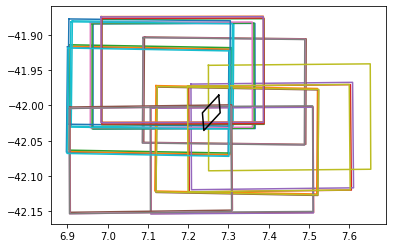

In [14]:
#Validating everything went as intended visually

pixel_number = 42004532
# print(pixel2ccd_dict.keys())
print(len(subpixel2ccd_dict_non_inclusive.keys()))

#for i, keys in enumerate(pixel2ccd_dict.keys()):
#break
ccd = subpixel2ccd_dict_non_inclusive[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd:
    #coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
    xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
    ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
    plt.plot(xs, ys)
#if i > 3:
#break

pixel_boundary = hp.boundaries(nside=NSIDE_SUB, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(), lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0], pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1], pixel_boundary_raDec[1][0])

plt.plot(pixel_boundary_raDec[0], pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()


### Replicating Above using HP.Query_Polygon for Speedup

In [ ]:
def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


subpixel2ccd_dict = defaultdict(list)
count_ex = 0

NSIDE = 256
NPIX = hp.nside2npix(NSIDE)

NSIDE_SUB = 4096
NPIX_SUB = hp.nside2npix(NSIDE_SUB)

for no in range(len(ra0)):  #range(len(ra0)):
    x_coord_polygon = np.array([ra0[no], ra1[no], ra2[no], ra3[no]])
    y_coord_polygon = np.array([dec0[no], dec1[no], dec2[no], dec3[no]])
    theta, phi = raDec2thetaPhi(x_coord_polygon, y_coord_polygon)

    ccd_vertices_3d = hp.ang2vec(theta=theta, phi=phi)

    # Now, Im getting all healpy pixels that a given CCD covers
    try:
        subpixels_for_ccd = hp.query_polygon(nside=NSIDE_SUB, vertices=ccd_vertices_3d, inclusive=False)
    except:
        count_ex += 1
        continue
    # This will give me the mapping CCD --> Pixel
    # Now, im reverting the mapping
    # For every pixel that a given CCD cuts, enter the CCD into the pixel dictionary
    # Mapping: Pixel --> CCDs
    for pixel in subpixels_for_ccd:
        subpixel2ccd_dict[pixel].append(no)

    if no % 70000 == 0:
        print(no / 70000, '%', count_ex)

with open('../bricks_data/pixel2ccd_4096.pickle', 'wb') as f:
    pickle.dump(subpixel2ccd_dict, f)
    f.close()

0.0 % 0
1.0 % 0
2.0 % 0
3.0 % 0
4.0 % 0
5.0 % 0
6.0 % 0
7.0 % 0
8.0 % 0
9.0 % 0
10.0 % 0
11.0 % 0
12.0 % 0
13.0 % 0
14.0 % 0
15.0 % 0
16.0 % 0
17.0 % 1
18.0 % 1
19.0 % 1
20.0 % 1
21.0 % 1
22.0 % 1
23.0 % 2
24.0 % 11
25.0 % 11
26.0 % 34
27.0 % 34
28.0 % 34
29.0 % 41
30.0 % 41
31.0 % 43
32.0 % 43
33.0 % 43
34.0 % 124
35.0 % 125
36.0 % 125
37.0 % 154
38.0 % 154
39.0 % 154
40.0 % 154
41.0 % 154
42.0 % 154
43.0 % 184
44.0 % 184
45.0 % 184
46.0 % 185
47.0 % 185
48.0 % 187
49.0 % 674
50.0 % 677
51.0 % 679
52.0 % 693
53.0 % 693
54.0 % 695
55.0 % 695
56.0 % 695
57.0 % 695
58.0 % 752
59.0 % 752
60.0 % 762
61.0 % 762
62.0 % 762
63.0 % 762
64.0 % 776
65.0 % 776
66.0 % 778
67.0 % 778
68.0 % 792
69.0 % 792
70.0 % 794
71.0 % 794
72.0 % 835
73.0 % 835
74.0 % 835
75.0 % 835
76.0 % 835
77.0 % 835
78.0 % 835
79.0 % 835
80.0 % 835
81.0 % 835
82.0 % 835
83.0 % 1733
84.0 % 1943
85.0 % 2444
86.0 % 2453
87.0 % 2453
88.0 % 2467
89.0 % 2467
90.0 % 2467
91.0 % 2467
92.0 % 2468
93.0 % 2750
94.0 % 2753
95.0 % 2774

In [ ]:
min = 1000
max = 0
aggregate = 0
index_max = 0
lens = np.zeros(len(subpixel2ccd_dict))

for i, pix in enumerate(subpixel2ccd_dict.keys()):
    no_ccds = len(subpixel2ccd_dict[pix])
    lens[i] = no_ccds
    aggregate += no_ccds
    if no_ccds > max:
        max = no_ccds
        index_max = pix
    if no_ccds < min:
        min = no_ccds

print("Mean CCD's per subpixel:", lens.mean())
print("Max CCD's per subpixel:", max)
print("Min CCD's per subpixel:", min)

In [ ]:
print("All CCD's for subpixel:", subpixel2ccd_dict[42004532])
print("All CCD's for subpixel:", subpixel2ccd_dict[42004532])



In [ ]:
print(len(subpixel2ccd_dict))


Using healpix map with NSIDE=128 and pixel area 0.210 sq.deg.


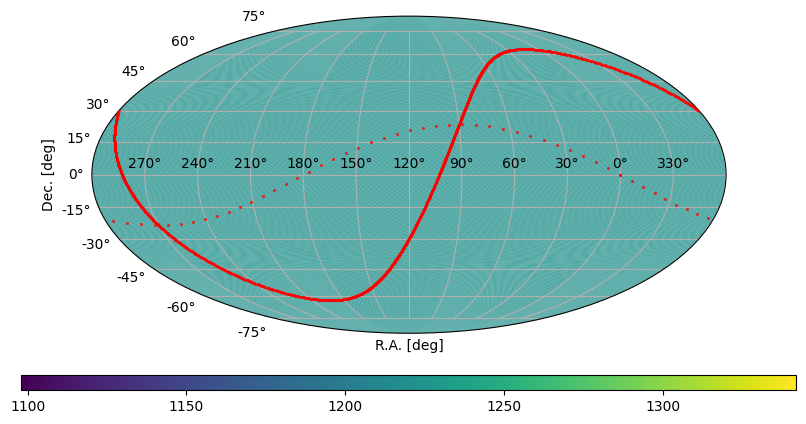

In [24]:
ax = plot_sky_binned(ra_sub, dec_sub, plot_type='healpix', max_bin_area=0.5, verbose=True)

